- 사기거래탐지

# EDA

### 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pgeocode #우편 변호 지원 
from sklearn.preprocessing import LabelEncoder


from haversine import haversine, haversine_vector, Unit # 지리적 거리 차이 계산
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pgeocode'

In [ ]:
card_df = pd.read_csv('../data/ftd/cards_data.csv')
trans_df = pd.read_csv('../data/ftd/transactions_data.csv')
user_df = pd.read_csv('../data/ftd/users_data.csv')
mcc_df = pd.read_json('../data/ftd/mcc_codes.json', orient='index').rename({0:'category'}, axis=1)
fraud_df = pd.read_json('../data/ftd/train_fraud_labels.json')

### 데이터별 컬럼 의미

In [ ]:
# card_df

- **id**: 카드 id 
- **client**: 고객 id
- **card_brand**: 카드사
- **card_type**: 카드 종류(신용/체크)
- **card_number**: 카드번호
- **expires**: 카드 만료기간
- **cvv**: 카드 인증코드
- **has_chip**: 카드 IC칩 보유 여부(IC칩 있을 시 카드 도용/복제에 상대적으로 안전)
- **num_cards_issued**: 문제 발생 횟수??
- **credit_limit**: 신용 한도
- **acct_open_date**: 계좌 개설일
- **year_pin_last_changed**: 카드 pin번호 최근 변경연도
- **card_on_dark_web**: 다크웹 사용?? => No만 존재 => 제거 가능

In [ ]:
# trans_df

- **id**: 거래식별번호
- **date**: 거래일자
- **client_id**: 고객id
- **card_id**: 카드id
- **amount**: 거래금액 => 음수 데이터 존재
- **use_chip**: 카드 결제 방식
    - Swipe Transaction: 마그네틱 카드로 긁어서 결제
    - Chip Transaction: ic칩 카드로 결제
    - Online Transaction: 온라인 결제
- **merchant_id**: 매장id
- **merchant_city**: 매장 위치(시)
- **merchant_state**: 매장 위치(주)
- **zip**: 매장 우편번호
- **mcc**: 매장 분류코드
- **errors**: 거래 성공 여부(결제 오류 시 오류 원인이 적혀있음)

In [ ]:
# user_df

- **id**: 고객id
- **current_age**: 현재 나이
- **retirement_age**: 퇴직 연령
- **birth_year**: 출생연도
- **gender**: 성별
- **address**: 주소
- **latitude**: 위도
- **longitude**: 경도
- **per_capita_income**: 1인당 소득 (전체 소득 / 인구 수)
- **yearly_income**: 연봉
- **total_debt**: 채무액
- **credit_score**: 신용점수
- **num_credit_cards**: 보유 중인 신용카드 수

In [ ]:
mcc_df.reset_index()

,index,category
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees
...,...,...
104,7549,Towing Services
105,5941,Sporting Goods Stores
106,5722,Household Appliance Stores
107,3009,Fabricated Structural Metal Products


- mcc별 상점 종류

In [ ]:
fraud_df.reset_index()

,index,target
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No
...,...,...
8914958,14064699,No
8914959,7676538,No
8914960,15131030,No
8914961,17244732,No


- 거래 id별 정상거래/사기거래 여부

### 데이터 살펴보기

In [ ]:
user_df = user_df.rename(columns={'id':'client_id'}) #user_df의 id를 client_id로 변경
card_user_df = card_df.merge(user_df, on='client_id') #카드 정보와 고객 정보를 병함(카드 데이터를 기준으로)

card_user_df = card_user_df.drop(columns=['card_number','cvv']) #카드 번호, cvv(보안 번호, cvc 번호랑 비슷함) 삭제
card_user_df = card_user_df.rename(columns={'id':'card_id'}) #card_df의 id를 card_id로 변경

In [ ]:
mcc_df = mcc_df.reset_index() #index 초기화
fraud_df = fraud_df.reset_index()

fraud_df = fraud_df.rename(columns={'index':'id','target':'fraud_label'}) #fraud_df의 index를 id로 변경,target를 fraud_label로 변경
mcc_df = mcc_df.rename(columns={'index':'mcc','category':'merchant_cat'}) #mcc_df의 index를 id로 변경,category를 merchant_cat로 변경

trans_df = trans_df.merge(fraud_df, on='id',how='left') #거래 정보와 사기 정보 결합
trans_df = trans_df.merge(mcc_df, on='mcc',how='left') #거래 정보와 판매점 정보 결합

#거래, 카드, 고객 정보 통합
trans_df = trans_df.merge(card_user_df, on=['card_id','client_id'],how='left')

#### trans_df

- date는 datetime으로 바꾸는게 좋아보임
- amount 음수인 경우 확인 필요

- errors의 결측치: 결제 성공 의미 => NaN대신 다른 값으로 변환 필요해 보임
- merchant_state => Italy 사기거래 백분율 65% => 단순 우연?
- zip => 별 의미 없는 데이터

#### 생각해볼만한 것

- card_brand와 사기거래 관련성
- card_type과 사기거래 관련성
- has_chip과 사기거래 관련성
- credit_limit과 사기거래 관련성

- date와 사기거래 관련성
- amount와 사기거래 관련성
- use_chip과 사기거래 관련성
- merchant_state와 사기거래 관련성
- category와 사기거래 관련성

- current_age와 사기거래 관련성
- gender과 사기거래 관련성
- latitude, longitude와 사기거래 관련성
- yearly_income와 사기거래 관련성
- credit_score와 사기거래 관련성
- num_credit_cards와 사기거래 관련성

### 중복값 확인

In [ ]:
#mcc_df[mcc_df.duplicated(keep=False)]

- trans_df와 합치면 상관없음

# Feature Engineering

해결해야 하는 문제

- 제거를 고려하는 변수들: address, latitude, longitude
  
- 해 마다 갱신 될 가능성이 높은 변수들: total_debt, credit_score(FICO Score로 추정됨)

- merchant_state,city 의 처리

In [ ]:
# mcc 범주화
food = ['Eating Places and Restaurants', 'Fast Food Restaurants', 'Drinking Places (Alcoholic Beverages)', 'Grocery Stores, Supermarkets', 
              'Miscellaneous Food Stores', 'Package Stores, Beer, Wine, Liquor', 'Wholesale Clubs', 'Discount Stores']

medical = ['Medical Services', 'Doctors, Physicians', 'Dentists and Orthodontists', 'Chiropractors', 'Podiatrists',
                    'Optometrists, Optical Goods and Eyeglasses', 'Hospitals', 'Drug Stores and Pharmacies']

transport = ['Service Stations', 'Automotive Service Shops', 'Automotive Body Repair Shops', 'Automotive Parts and Accessories Stores',
                       'Taxicabs and Limousines', 'Bus Lines', 'Passenger Railways', 'Railroad Passenger Transport', 'Railroad Freight',
                       'Motor Freight Carriers and Trucking', 'Airlines', 'Cruise Lines', 'Lodging - Hotels, Motels, Resorts',
                       'Local and Suburban Commuter Transportation']

service = ['Laundry Services', 'Car Washes', 'Towing Services', 'Cleaning and Maintenance Services', 'Tax Preparation Services',
                   'Accounting, Auditing, and Bookkeeping Services', 'Legal Services and Attorneys', 'Detective Agencies, Security Services', 'Money Transfer',
                   'Insurance Sales, Underwriting', 'Travel Agencies']

retail = ['Department Stores', 'Family Clothing Stores', "Women's Ready-To-Wear Stores", 'Shoe Stores', 'Sports Apparel, Riding Apparel Stores',
              'Sporting Goods Stores', 'Leather Goods', 'Precious Stones and Metals', 'Antique Shops', 'Music Stores - Musical Instruments',
              'Artist Supply Stores, Craft Shops', 'Book Stores', 'Books, Periodicals, Newspapers', 'Electronics Stores',
              'Computers, Computer Peripheral Equipment', 'Digital Goods - Media, Books, Apps', 'Digital Goods - Games', 'Cosmetic Stores',
              'Beauty and Barber Shops', 'Gift, Card, Novelty Stores', 'Miscellaneous Home Furnishing Stores', 
              'Furniture, Home Furnishings, and Equipment Stores', 'Upholstery and Drapery Stores', 'Lighting, Fixtures, Electrical Supplies',
              'Floor Covering Stores', 'Lawn and Garden Supply Stores', 'Gardening Supplies', 'Hardware Stores', 'Household Appliance Stores',
              'Florists Supplies, Nursery Stock and Flowers', 'Non-Precious Metal Services']

industry = ['Lumber and Building Materials', 'Brick, Stone, and Related Materials', 'Industrial Equipment and Supplies',
                    'Tools, Parts, Supplies Manufacturing', 'Heating, Plumbing, Air Conditioning Contractors', 'Fabricated Structural Metal Products',
                    'Steel Products Manufacturing', 'Steelworks', 'Ironwork', 'Welding Repair', 'Electroplating, Plating, Polishing Services',
                    'Heat Treating Metal Services', 'Bolt, Nut, Screw, Rivet Manufacturing', 'Coated and Laminated Products', 'Non-Ferrous Metal Foundries',
                    'Steel Drums and Barrels', 'Miscellaneous Metal Fabrication', 'Miscellaneous Metals', 'Miscellaneous Fabricated Metal Products',
                    'Miscellaneous Metalwork', 'Pottery and Ceramics', 'Semiconductors and Related Devices', 'Ship Chandlers',
                    'Utilities - Electric, Gas, Water, Sanitary', 'Telecommunication Services', 'Computer Network Services', 
                    'Cable, Satellite, and Other Pay Television Services', 'Postal Services - Government Only', 'Tolls and Bridge Fees', 
                    'Amusement Parks, Carnivals, Circuses', 'Motion Picture Theaters', 'Theatrical Producers', 'Recreational Sports, Clubs', 
                    'Athletic Fields, Commercial Sports', 'Betting (including Lottery Tickets, Casinos)', 'Miscellaneous Machinery and Parts Manufacturing']

In [ ]:
trans_df.loc[trans_df['merchant_cat'].isin(food), 'merchant_cat'] = 'food'
trans_df.loc[trans_df['merchant_cat'].isin(medical), 'merchant_cat'] = 'medical'
trans_df.loc[trans_df['merchant_cat'].isin(transport), 'merchant_cat'] = 'transport'
trans_df.loc[trans_df['merchant_cat'].isin(service), 'merchant_cat'] = 'service'
trans_df.loc[trans_df['merchant_cat'].isin(retail), 'merchant_cat'] = 'retail'
trans_df.loc[trans_df['merchant_cat'].isin(industry), 'merchant_cat'] = 'industry'

In [ ]:
trans_df['errors'] = trans_df['errors'].fillna(0) #정상 거래는 0값으로 처리

#merchant_city가 ONLINE 일 떄 merchant_state도 ONLINE으로 변경
trans_df.loc[trans_df['merchant_city'] == 'ONLINE', 'merchant_state'] = 'ONLINE'

#고객 ID, 카드 ID, 다크웹에서 카드?,거래 id, 상점 id, 상점 카테고리 식별 번호 삭제
trans_df = trans_df.drop(columns=['id','merchant_id','mcc','client_id','card_on_dark_web'])

In [ ]:
trans_df['date'] = pd.to_datetime(trans_df['date']) #date의 데이터 구조를 datetime으로 변환

#금액에서 $표시를 제거해서 돈과 관련된 수치를 숫자로 변환
trans_df['amount'] = pd.to_numeric(trans_df['amount'].str.split('$', expand=True)[1]) #
trans_df['credit_limit'] = pd.to_numeric(trans_df['credit_limit'].str.split('$', expand=True)[1]) #
trans_df['per_capita_income'] = pd.to_numeric(trans_df['per_capita_income'].str.split('$', expand=True)[1])
trans_df['yearly_income'] = pd.to_numeric(trans_df['yearly_income'].str.split('$', expand=True)[1])
trans_df['total_debt'] = pd.to_numeric(trans_df['total_debt'].str.split('$', expand=True)[1])

In [ ]:
#거래 날짜와 고객,카드 정보를 통해 시간과 관련된 새로운 피쳐 생성

trans_df['day'] = trans_df['date'].dt.day #거래 당시의 일 생성
trans_df['month'] = trans_df['date'].dt.month #거래 당시의 월 생성
trans_df['year'] = trans_df['date'].dt.year #거래 당시의 년 생성

trans_df['expire_month'] = pd.to_numeric(trans_df['expires'].str.split('/', expand=True)[0]) #카드 만료 날의 월 
trans_df['expire_year'] = pd.to_numeric(trans_df['expires'].str.split('/', expand=True)[1]) #카드 만료 날의 년

trans_df['acct_open_date_month'] = pd.to_numeric(trans_df['acct_open_date'].str.split('/', expand=True)[0]) #계좌 개설 날의 월 
trans_df['acct_open_date_year'] = pd.to_numeric(trans_df['acct_open_date'].str.split('/', expand=True)[1]) #계좌 개설 날의 년

trans_df['current_age'] = trans_df['year'] - trans_df['birth_year'] #현재 나이를 2019년이 아닌 거래 날짜를 기준으로 변경
trans_df['year_since_pin_changed'] = trans_df['year'] - trans_df['year_pin_last_changed'] #핀 번호 변경으로 부터 지난 해 기간
trans_df['year_since_pin_changed'] = trans_df['year_since_pin_changed'].clip(lower=0) #핀 번호 갱신 기간이 음수인 경우 0으로 변환
trans_df['years_to_retirement'] = trans_df['retirement_age'] - trans_df['current_age'] #은퇴까지 남은 년

trans_df['month_to_expires'] = (12*(trans_df['expire_year'] - trans_df['year']) 
                                + (trans_df['expire_month'] - trans_df['month'])) #카드 만료까지 남은 개월 수

trans_df['month_to_acct_open'] = (12*(trans_df['year'] - trans_df['acct_open_date_year']) 
                                + (trans_df['month'] - trans_df['acct_open_date_month'])) #계좌 개설 후 지난 개월 수


In [ ]:
trans_df['hour'] = trans_df['date'].dt.hour #거래 당시의 시간 
trans_df['min'] = trans_df['date'].dt.minute #거래 당시의 분  

trans_df['time'] = 60*trans_df['hour'] + trans_df['min'] #거래 당시의 시간대

#해당 고객의 최근 거래 7건의 시간대의 이동 평균 계산 (사용한 카드 기준)
trans_df['time_7_ma'] = trans_df.groupby('card_id')['time'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
trans_df['time_7_ma'] = trans_df['time_7_ma'].round(2)

In [ ]:
trans_df = trans_df.drop(columns=['birth_year','birth_month','date','year_pin_last_changed','retirement_age','expires','acct_open_date',
                                 'expire_month','expire_year','acct_open_date_month','acct_open_date_year'])

- 소비자 물가 지수(CPI)로 년마다 연봉 갱신

|연도|소비자 물가 지수|단위 환산|
|------|---|---|
|2010년|218.1|85.30|
|2011년|224.9|87.95|
|2012년|229.6|89.79|
|2013년|232.9|91.08|
|2014년|236.7|92.57|
|2015년|237.0|92.69|
|2016년|240.0|93.86|
|2017년|245.1|95.85|
|2018년|251.1|98.20|
|2019년|255.7|100|

출처: https://ko.tradingeconomics.com/united-states

In [ ]:
#소비자 물기 지수(CPI)로 연봉을 평준화 
CPI = {2019:1, 2018:0.982 ,2017:0.9585,2016:0.9386, 2015:0.9269, 2014:0.9257, 2013:0.9108, 2012:0.8979, 2011:0.8795, 2010:0.853}

trans_df['CPI'] = trans_df['year'].map(CPI)
trans_df['per_capita_income'] = trans_df['per_capita_income']*trans_df['CPI'] #지역 연봉 * CPI 지수 가중치
trans_df['yearly_income'] = trans_df['yearly_income']*trans_df['CPI'] #연봉 * CPI 지수 가중치
trans_df = trans_df.drop(columns=['CPI'])

In [ ]:
#지리 정보를 이용한 feature engineering

manual_coords = {
    '30399': (33.7490, -84.3880), '94101': (37.7834, -122.4194),
    '98205': (47.9790, -122.2021), '10072': (40.7766, -73.9525),
    '19640': (40.3356, -75.9269), '45418': (39.7589, -84.1916),
    '21748': (39.6418, -77.7200), '10558': (40.9126, -73.8385),
    '92164': (32.7157, -117.1611), '14645': (43.1566, -77.6088),
    '33121': (25.7617, -80.1918), '17767': (41.2951, -77.1641),
    '16532': (42.1292, -80.0851), '29573': (33.6891, -78.8867),
    '19388': (39.9607, -75.6055), '41338': (37.5551, -83.3882),
    '21681': (39.2157, -76.0694), '19483': (40.0970, -75.3888),
    '40446': (37.4298, -83.9785), '92412': (34.1083, -117.2898),
    '11594': (40.7559, -73.5876), '25965': (37.6729, -80.8906)
} #우편번호 라이브러리에 등록되지 않은 위치 정보

#상점 우편 번호로 상점의 위도 경도 지리 정보 추출
geo_locator = pgeocode.Nominatim('us') #미국 우편 번호 객체 생성

trans_df['zip'].fillna(0, inplace=True)
trans_df['zip_str'] = trans_df['zip'].astype(int).astype(str).str.zfill(5)
geo_info = geo_locator.query_postal_code(trans_df['zip_str'].tolist()) #우편 번호를 위도, 경도로 변환

trans_df['market_latitude'] = geo_info['latitude'] #거래 데이터에 상점의 위도, 경도 정보 저장
trans_df['market_longitude'] = geo_info['longitude']

lat_map = {zip_code: coords[0] for zip_code, coords in manual_coords.items()} #위도 정보 변환
lon_map = {zip_code: coords[1] for zip_code, coords in manual_coords.items()} #경도 정보 변환

trans_df['market_latitude'] = trans_df['market_latitude'].fillna(trans_df['zip_str'].map(lat_map)) #결측치에 위도, 경도 정보 저장
trans_df['market_longitude'] = trans_df['market_longitude'].fillna(trans_df['zip_str'].map(lon_map))

#상점과 고객 주소 간의 거리 계산
client_coords = list(zip(trans_df['latitude'], trans_df['longitude'])) #고객 주소 좌표
market_coords = list(zip(trans_df['market_latitude'], trans_df['market_longitude'])) #상점 주소 좌표
trans_df['distance_km'] = haversine_vector(client_coords, market_coords, unit=Unit.KILOMETERS) #고객과 상점 거리를 km 단위로 계산
trans_df['distance_km'] = trans_df['distance_km'].round(2)

#해당 고객의 최근 거래 7건의 이동 평균 계산
trans_df['distance_7_ma'] = trans_df.groupby('card_id')['distance_km'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

# 소수점 둘째 자리까지 반올림
trans_df['distance_7_ma'] = trans_df['distance_7_ma'].round(2)

us_state_codes = {
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
    'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
    'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
    'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'} #미국 50개 주 +D.C(워싱턴)

condition = trans_df['merchant_state'].isin(us_state_codes) # 상점 위치가 미국 내인지 판단
trans_df['national'] = np.where(condition, 'domestic', 'overseas') #미국 내이면 'domestic', 해외면 'overseas' 값을 가짐

#상점 위치가 해외이면 merchant_state 값을 overseas로 변환
condition2 = (trans_df['national'] == 'overseas') & (trans_df['merchant_city'] != 'ONLINE')
trans_df.loc[condition2, 'merchant_state'] = 'overseas'

In [ ]:
#거래 금액 관련 feature-engineering

condition = trans_df['amount'] < 0 #거래 금액이 음수인지 판단(환불 거래)
trans_df['refund'] = np.where(condition,1,0)
trans_df['amount'] = np.abs(trans_df['amount']) #거래 금액을 양수로 바꿈

window_size = 200 #최근 200개 데이터 선별

def count_current_customer(window):
    current_customer = window.iloc[-1]
    return (window == current_customer).sum()

trans_df['recent_trans'] = trans_df['card_id'].rolling(window=window_size, min_periods=1).apply(count_current_customer, raw=False)

#trans_df['combo_id'] = trans_df['card_id'].astype(str) + '_' + trans_df['refund'].astype(str)

In [ ]:
#필요 없는 정보 제거
trans_df = trans_df.drop(columns=['address','latitude','longitude','zip','zip_str','market_latitude','market_longitude','card_id','merchant_city','national','time'])

In [ ]:
train_trans_df = trans_df[trans_df['fraud_label'].notnull()] # 사기 정보가 있는 데이터 900만개
test_trans_df = trans_df[trans_df['fraud_label'].isnull()] # 사기 정보가 없는 데이터  400만개

#사기 거래 정보 값을 Yes, NO에서 1,0으로 변경
YN_dict = {"Yes": 1, "No" : 0}
train_trans_df['fraud_label'] = train_trans_df['fraud_label'].map(YN_dict)

In [ ]:
#feature
train_trans_df.columns

Index(['amount', 'use_chip', 'merchant_state', 'errors', 'fraud_label',
       'merchant_cat', 'card_brand', 'card_type', 'has_chip',
       'num_cards_issued', 'credit_limit', 'current_age', 'gender',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'day', 'month', 'year', 'year_since_pin_changed',
       'years_to_retirement', 'month_to_expires', 'month_to_acct_open', 'hour',
       'min', 'time_7_ma', 'distance_km', 'distance_7_ma', 'refund',
       'recent_trans', 'combo_id'],
      dtype='object')

<span style="font-size: 22px; color: black">**추가된 변수**</span>

- **day**: 거래된 일
- **month**: 거래된 월
- **year**: 거래된 년
- **hour**: 거래된 시간
- **min**: 거래된 분
- **year_since_pin_changed**: 핀 번호 변경으로 부터 지난 년
- **years_to_retirement**: 은퇴까지 남은 년
- **month_to_expires**: 카드 만료까지 남은 달
- **month_to_acct_open**: 계좌 개설로 부터 지난 달
- **distance_km**: 상점과 고객 주소의 거리 차이(km)
- **distance_7_ma**" 최근 7번 거래의 상점-고객 거리의 이동 평균 (카드 기준) -차이로 바꿀 예정
- **time_7_ma**" 최근 7번 거래의 거래 시간의 이동 평균 (카드 기준) -차이로 바꿀 예정
- **refund**: 환불 여부
- **recent_trans**:최근 거래 횟수
- 최근 환불 횟수(추가 예정)
- 최근 7번 거래의 거래 금액 평균(추가 예정) -차이로 바꿀 예정
- 

<span style="font-size: 22px; color: black">**변경된 변수**</span>

- **fraud_label**: NO, Yes를 0,1로 변경
- **current_age**: 현재 나이를 2019년 기준에서 거래 당시 시간으로 변경
- **per_capita_income**: 수입 기준을 2019년에서 CPA를 적용해서 년마다 갱신
- **yearly_income**: 연봉 기준을 2019년에서 CPA를 적용해서 년마다 갱신
- **merchant_state**: 해외는 overseas, 미국 내는 주, 온라인 거래는 ONLINE 으로 변경


In [ ]:
train_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8914963 entries, 0 to 13305912
Data columns (total 33 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   amount                  float64
 1   use_chip                object 
 2   merchant_state          object 
 3   errors                  object 
 4   fraud_label             int64  
 5   merchant_cat            object 
 6   card_brand              object 
 7   card_type               object 
 8   has_chip                object 
 9   num_cards_issued        int64  
 10  credit_limit            int64  
 11  current_age             int64  
 12  gender                  object 
 13  per_capita_income       float64
 14  yearly_income           float64
 15  total_debt              int64  
 16  credit_score            int64  
 17  num_credit_cards        int64  
 18  day                     int32  
 19  month                   int32  
 20  year                    int32  
 21  year_since_pin_changed  int64  
 22

In [ ]:
train_trans_df.head()

,amount,use_chip,merchant_state,errors,fraud_label,merchant_cat,card_brand,card_type,has_chip,num_cards_issued,...,month_to_expires,month_to_acct_open,hour,min,time_7_ma,distance_km,distance_7_ma,refund,recent_trans,combo_id
0,77.00,Swipe Transaction,ND,0,0,food,Mastercard,Debit (Prepaid),YES,2,...,150,20,0,1,1.0,95.08,95.08,1,1.0,2972_1
1,14.57,Swipe Transaction,IA,0,0,retail,Mastercard,Credit,YES,1,...,179,52,0,2,2.0,98.56,98.56,0,1.0,4575_0
2,80.00,Swipe Transaction,CA,0,0,service,Mastercard,Debit,YES,1,...,124,48,0,2,2.0,7.14,7.14,0,1.0,102_0
4,46.41,Swipe Transaction,MD,0,0,food,Visa,Debit,YES,1,...,120,6,0,6,6.0,1.27,1.27,0,1.0,3915_0
5,4.81,Swipe Transaction,NY,0,0,retail,Mastercard,Debit (Prepaid),YES,1,...,50,24,0,7,7.0,6.99,6.99,0,1.0,165_0


- target은 fraud_label
- fraud_label 값이 0: 정상 거래 1: 사기 거래

- 학습할 데이터: train_trans_df (X,y 분리 안되어 있음)

# EDA

### 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
card_df = pd.read_csv('../data/ftd/cards_data.csv')
trans_df = pd.read_csv('../data/ftd/transactions_data.csv')
user_df = pd.read_csv('../data/ftd/users_data.csv')
mcc_df = pd.read_json('../data/ftd/mcc_codes.json', orient='index').rename({0:'category'}, axis=1)
fraud_df = pd.read_json('../data/ftd/train_fraud_labels.json')

### 데이터별 컬럼 의미

In [3]:
# card_df

- **id**: 카드 id 
- **client**: 고객 id
- **card_brand**: 카드사
- **card_type**: 카드 종류(신용/체크)
- **card_number**: 카드번호
- **expires**: 카드 만료기간
- **cvv**: 카드 인증코드
- **has_chip**: 카드 IC칩 보유 여부(IC칩 있을 시 카드 도용/복제에 상대적으로 안전)
- **num_cards_issued**: 문제 발생 횟수??
- **credit_limit**: 신용 한도
- **acct_open_date**: 계좌 개설일
- **year_pin_last_changed**: 카드 pin번호 최근 변경연도
- **card_on_dark_web**: 다크웹 사용?? => No만 존재 => 제거 가능

In [4]:
# trans_df

- **id**: 거래식별번호
- **date**: 거래일자
- **client_id**: 고객id
- **card_id**: 카드id
- **amount**: 거래금액 => 음수 데이터 존재
- **use_chip**: 카드 결제 방식
    - Swipe Transaction: 마그네틱 카드로 긁어서 결제
    - Chip Transaction: ic칩 카드로 결제
    - Online Transaction: 온라인 결제
- **merchant_id**: 매장id
- **merchant_city**: 매장 위치(시)
- **merchant_state**: 매장 위치(주)
- **zip**: 매장 우편번호
- **mcc**: 매장 분류코드
- **errors**: 거래 성공 여부(결제 오류 시 오류 원인이 적혀있음)

In [5]:
# user_df

- **id**: 고객id
- **current_age**: 현재 나이
- **retirement_age**: 퇴직 연령
- **birth_year**: 출생연도
- **gender**: 성별
- **address**: 주소
- **latitude**: 위도
- **longitude**: 경도
- **per_capita_income**: 1인당 소득 (전체 소득 / 인구 수)
- **yearly_income**: 연봉
- **total_debt**: 채무액
- **credit_score**: 신용점수
- **num_credit_cards**: 보유 중인 신용카드 수

In [6]:
mcc_df.reset_index()

,index,category
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees
...,...,...
104,7549,Towing Services
105,5941,Sporting Goods Stores
106,5722,Household Appliance Stores
107,3009,Fabricated Structural Metal Products


- mcc별 상점 종류

In [7]:
fraud_df.reset_index()

,index,target
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No
...,...,...
8914958,14064699,No
8914959,7676538,No
8914960,15131030,No
8914961,17244732,No


- 거래 id별 정상거래/사기거래 여부

### 데이터 살펴보기

In [8]:
user_df = user_df.rename(columns={'id':'client_id'}) #user_df의 id를 client_id로 변경
card_user_df = card_df.merge(user_df, on='client_id') #카드 정보와 고객 정보를 병함(카드 데이터를 기준으로)

card_user_df = card_user_df.drop(columns=['card_number','cvv']) #카드 번호, cvv(보안 번호, cvc 번호랑 비슷함) 삭제
card_user_df = card_user_df.rename(columns={'id':'card_id'}) #card_df의 id를 card_id로 변경

In [9]:
mcc_df = mcc_df.reset_index() #index 초기화
fraud_df = fraud_df.reset_index()

fraud_df = fraud_df.rename(columns={'index':'id','target':'fraud_label'}) #fraud_df의 index를 id로 변경,target를 fraud_label로 변경
mcc_df = mcc_df.rename(columns={'index':'mcc','category':'merchant_cat'}) #mcc_df의 index를 id로 변경,category를 merchant_cat로 변경

trans_df = trans_df.merge(fraud_df, on='id',how='left') #거래 정보와 사기 정보 결합
trans_df = trans_df.merge(mcc_df, on='mcc',how='left') #거래 정보와 판매점 정보 결합

#거래, 카드, 고객 정보 통합
trans_df = trans_df.merge(card_user_df, on=['card_id','client_id'],how='left')

#### trans_df

- date는 datetime으로 바꾸는게 좋아보임
- amount 음수인 경우 확인 필요

- errors의 결측치: 결제 성공 의미 => NaN대신 다른 값으로 변환 필요해 보임
- merchant_state => Italy 사기거래 백분율 65% => 단순 우연?
- zip => 별 의미 없는 데이터

#### 생각해볼만한 것

- card_brand와 사기거래 관련성
- card_type과 사기거래 관련성
- has_chip과 사기거래 관련성
- credit_limit과 사기거래 관련성

- date와 사기거래 관련성
- amount와 사기거래 관련성
- use_chip과 사기거래 관련성
- merchant_state와 사기거래 관련성
- category와 사기거래 관련성

- current_age와 사기거래 관련성
- gender과 사기거래 관련성
- latitude, longitude와 사기거래 관련성
- yearly_income와 사기거래 관련성
- credit_score와 사기거래 관련성
- num_credit_cards와 사기거래 관련성

### 중복값 확인

In [10]:
#mcc_df[mcc_df.duplicated(keep=False)]

- trans_df와 합치면 상관없음

# Feature Engineering

해결해야 하는 문제

- 제거를 고려하는 변수들: address, latitude, longitude
  
- 해 마다 갱신 될 가능성이 높은 변수들: per_capita_income, yearly_income, total_debt, credit_score

- merchant_state,city 의 처리

- year_since_pin_changed의 음수 값 처리

In [11]:
# mcc 범주화
food = ['Eating Places and Restaurants', 'Fast Food Restaurants', 'Drinking Places (Alcoholic Beverages)', 'Grocery Stores, Supermarkets', 
              'Miscellaneous Food Stores', 'Package Stores, Beer, Wine, Liquor', 'Wholesale Clubs', 'Discount Stores']

medical = ['Medical Services', 'Doctors, Physicians', 'Dentists and Orthodontists', 'Chiropractors', 'Podiatrists',
                    'Optometrists, Optical Goods and Eyeglasses', 'Hospitals', 'Drug Stores and Pharmacies']

transport = ['Service Stations', 'Automotive Service Shops', 'Automotive Body Repair Shops', 'Automotive Parts and Accessories Stores',
                       'Taxicabs and Limousines', 'Bus Lines', 'Passenger Railways', 'Railroad Passenger Transport', 'Railroad Freight',
                       'Motor Freight Carriers and Trucking', 'Airlines', 'Cruise Lines', 'Lodging - Hotels, Motels, Resorts',
                       'Local and Suburban Commuter Transportation']

service = ['Laundry Services', 'Car Washes', 'Towing Services', 'Cleaning and Maintenance Services', 'Tax Preparation Services',
                   'Accounting, Auditing, and Bookkeeping Services', 'Legal Services and Attorneys', 'Detective Agencies, Security Services', 'Money Transfer',
                   'Insurance Sales, Underwriting', 'Travel Agencies']

retail = ['Department Stores', 'Family Clothing Stores', "Women's Ready-To-Wear Stores", 'Shoe Stores', 'Sports Apparel, Riding Apparel Stores',
              'Sporting Goods Stores', 'Leather Goods', 'Precious Stones and Metals', 'Antique Shops', 'Music Stores - Musical Instruments',
              'Artist Supply Stores, Craft Shops', 'Book Stores', 'Books, Periodicals, Newspapers', 'Electronics Stores',
              'Computers, Computer Peripheral Equipment', 'Digital Goods - Media, Books, Apps', 'Digital Goods - Games', 'Cosmetic Stores',
              'Beauty and Barber Shops', 'Gift, Card, Novelty Stores', 'Miscellaneous Home Furnishing Stores', 
              'Furniture, Home Furnishings, and Equipment Stores', 'Upholstery and Drapery Stores', 'Lighting, Fixtures, Electrical Supplies',
              'Floor Covering Stores', 'Lawn and Garden Supply Stores', 'Gardening Supplies', 'Hardware Stores', 'Household Appliance Stores',
              'Florists Supplies, Nursery Stock and Flowers', 'Non-Precious Metal Services']

industry = ['Lumber and Building Materials', 'Brick, Stone, and Related Materials', 'Industrial Equipment and Supplies',
                    'Tools, Parts, Supplies Manufacturing', 'Heating, Plumbing, Air Conditioning Contractors', 'Fabricated Structural Metal Products',
                    'Steel Products Manufacturing', 'Steelworks', 'Ironwork', 'Welding Repair', 'Electroplating, Plating, Polishing Services',
                    'Heat Treating Metal Services', 'Bolt, Nut, Screw, Rivet Manufacturing', 'Coated and Laminated Products', 'Non-Ferrous Metal Foundries',
                    'Steel Drums and Barrels', 'Miscellaneous Metal Fabrication', 'Miscellaneous Metals', 'Miscellaneous Fabricated Metal Products',
                    'Miscellaneous Metalwork', 'Pottery and Ceramics', 'Semiconductors and Related Devices', 'Ship Chandlers',
                    'Utilities - Electric, Gas, Water, Sanitary', 'Telecommunication Services', 'Computer Network Services', 
                    'Cable, Satellite, and Other Pay Television Services', 'Postal Services - Government Only', 'Tolls and Bridge Fees', 
                    'Amusement Parks, Carnivals, Circuses', 'Motion Picture Theaters', 'Theatrical Producers', 'Recreational Sports, Clubs', 
                    'Athletic Fields, Commercial Sports', 'Betting (including Lottery Tickets, Casinos)', 'Miscellaneous Machinery and Parts Manufacturing']

In [12]:
trans_df.loc[trans_df['merchant_cat'].isin(food), 'merchant_cat'] = 'food'
trans_df.loc[trans_df['merchant_cat'].isin(medical), 'merchant_cat'] = 'medical'
trans_df.loc[trans_df['merchant_cat'].isin(transport), 'merchant_cat'] = 'transport'
trans_df.loc[trans_df['merchant_cat'].isin(service), 'merchant_cat'] = 'service'
trans_df.loc[trans_df['merchant_cat'].isin(retail), 'merchant_cat'] = 'retail'
trans_df.loc[trans_df['merchant_cat'].isin(industry), 'merchant_cat'] = 'industry'

In [13]:
trans_df['errors'] = trans_df['errors'].fillna(0) #정상 거래는 0값으로 처리

#merchant_city가 ONLINE 일 떄 merchant_state도 ONLINE으로 변경
trans_df.loc[trans_df['merchant_city'] == 'ONLINE', 'merchant_state'] = 'ONLINE'

trans_df['errors'] = trans_df['errors'].fillna(0) #정상 거래는 0값으로 처리

trans_df = trans_df.drop(columns=['zip','id','merchant_id','mcc','client_id','card_id','card_on_dark_web'])
#고객 ID, 카드 ID, 다크웹에서 카드?, 상점 우편 번호 거래 id, 상점 id 삭제

In [14]:
trans_df['date'] = pd.to_datetime(trans_df['date']) #date의 데이터 구조를 datetime으로 변환

#금액에서 $표시를 제거해서 돈과 관련된 수치를 숫자로 변환
trans_df['amount'] = pd.to_numeric(trans_df['amount'].str.split('$', expand=True)[1]) #
trans_df['credit_limit'] = pd.to_numeric(trans_df['credit_limit'].str.split('$', expand=True)[1]) #
trans_df['per_capita_income'] = pd.to_numeric(trans_df['per_capita_income'].str.split('$', expand=True)[1])
trans_df['yearly_income'] = pd.to_numeric(trans_df['yearly_income'].str.split('$', expand=True)[1])
trans_df['total_debt'] = pd.to_numeric(trans_df['total_debt'].str.split('$', expand=True)[1])

In [15]:
#거래 날짜와 고객,카드 정보를 통해 시간과 관련된 새로운 피쳐 생성

trans_df['day'] = trans_df['date'].dt.day #거래 날짜의 일 생성
trans_df['month'] = trans_df['date'].dt.month #거래 날짜의 월 생성
trans_df['year'] = trans_df['date'].dt.year #거래 날짜의 년 생성

trans_df['expire_month'] = pd.to_numeric(trans_df['expires'].str.split('/', expand=True)[0]) #카드 만료 날의 월 
trans_df['expire_year'] = pd.to_numeric(trans_df['expires'].str.split('/', expand=True)[1]) #카드 만료 날의 년

trans_df['acct_open_date_month'] = pd.to_numeric(trans_df['acct_open_date'].str.split('/', expand=True)[0]) #계좌 개설 날의 월 
trans_df['acct_open_date_year'] = pd.to_numeric(trans_df['acct_open_date'].str.split('/', expand=True)[1]) #계좌 개설 날의 년

trans_df['current_age'] = trans_df['year'] - trans_df['birth_year'] #현재 나이를 2019년이 아닌 거래 날짜를 기준으로 변경
trans_df['year_since_pin_changed'] = trans_df['year'] - trans_df['year_pin_last_changed'] #핀 번호 변경으로 부터 지난 해 기간
trans_df['years_to_retirement'] = trans_df['retirement_age'] - trans_df['current_age'] #은퇴까지 남은 년

trans_df['month_to_expires'] = (12*(trans_df['expire_year'] - trans_df['year']) 
                                + (trans_df['expire_month'] - trans_df['month'])) #카드 만료까지 남은 개월 수

trans_df['month_to_acct_open'] = (12*(trans_df['year'] - trans_df['acct_open_date_year']) 
                                + (trans_df['month'] - trans_df['acct_open_date_month'])) #계좌 개설 후 지난 개월 수


In [16]:
trans_df = trans_df.drop(columns=['birth_year','birth_month','date','year_pin_last_changed','retirement_age','expires','acct_open_date',
                                 'expire_month','expire_year','acct_open_date_month','acct_open_date_year'])

|연도|소비자 물가 지수|단위 환산|
|------|---|---|
|2010년|218.1|85.30|
|2011년|224.9|87.95|
|2012년|229.6|89.79|
|2013년|232.9|91.08|
|2014년|236.7|92.57|
|2015년|237.0|92.69|
|2016년|240.0|93.86|
|2017년|245.1|95.85|
|2018년|251.1|98.20|
|2019년|255.7|100|

출처: https://ko.tradingeconomics.com/united-states

In [17]:
#소비자 물기 지수(CPI)로 연봉을 평준화 
CPI = {2019:1, 2018:0.982 ,2017:0.9585,2016:0.9386, 2015:0.9269, 2014:0.9257, 2013:0.9108, 2012:0.8979, 2011:0.8795, 2010:0.853}

trans_df['CPI'] = trans_df['year'].map(CPI)
trans_df['per_capita_income'] = trans_df['per_capita_income']*trans_df['CPI'] #지역 연봉 * CPI 지수 가중치
trans_df['yearly_income'] = trans_df['yearly_income']*trans_df['CPI'] #연봉 * CPI 지수 가중치
trans_df = trans_df.drop(columns=['CPI'])

In [18]:
#우선 중요도가 낮은 피쳐들을 제거(추후 바뀔 수 있음)
trans_df = trans_df.drop(columns=['address','latitude','longitude'])

In [19]:
train_trans_df = trans_df[trans_df['fraud_label'].notnull()] # 사기 정보가 있는 데이터 900만개
test_trans_df = trans_df[trans_df['fraud_label'].isnull()] # 사기 정보가 없는 데이터  400만개

#사기 거래 정보 값을 Yes, NO에서 1,0으로 변경
YN_dict = {"Yes": 1, "No" : 0}
train_trans_df['fraud_label'] = train_trans_df['fraud_label'].map(YN_dict)

In [20]:
#feature
train_trans_df.columns

Index(['amount', 'use_chip', 'merchant_city', 'merchant_state', 'errors',
       'fraud_label', 'merchant_cat', 'card_brand', 'card_type', 'has_chip',
       'num_cards_issued', 'credit_limit', 'current_age', 'gender',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'day', 'month', 'year', 'year_since_pin_changed',
       'years_to_retirement', 'month_to_expires', 'month_to_acct_open'],
      dtype='object')

In [21]:
train_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8914963 entries, 0 to 13305912
Data columns (total 26 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   amount                  float64
 1   use_chip                object 
 2   merchant_city           object 
 3   merchant_state          object 
 4   errors                  object 
 5   fraud_label             int64  
 6   merchant_cat            object 
 7   card_brand              object 
 8   card_type               object 
 9   has_chip                object 
 10  num_cards_issued        int64  
 11  credit_limit            int64  
 12  current_age             int64  
 13  gender                  object 
 14  per_capita_income       float64
 15  yearly_income           float64
 16  total_debt              int64  
 17  credit_score            int64  
 18  num_credit_cards        int64  
 19  day                     int32  
 20  month                   int32  
 21  year                    int32  
 22

In [22]:
train_trans_df.head()

,amount,use_chip,merchant_city,merchant_state,errors,fraud_label,merchant_cat,card_brand,card_type,has_chip,...,total_debt,credit_score,num_credit_cards,day,month,year,year_since_pin_changed,years_to_retirement,month_to_expires,month_to_acct_open
0,-77.00,Swipe Transaction,Beulah,ND,0,0,food,Mastercard,Debit (Prepaid),YES,...,110153,740,4,1,1,2010,2,46,150,20
1,14.57,Swipe Transaction,Bettendorf,IA,0,0,retail,Mastercard,Credit,YES,...,112139,834,5,1,1,2010,-5,28,179,52
2,80.00,Swipe Transaction,Vista,CA,0,0,service,Mastercard,Debit,YES,...,36540,686,3,1,1,2010,2,25,124,48
4,46.41,Swipe Transaction,Harwood,MD,0,0,food,Visa,Debit,YES,...,96182,711,2,1,1,2010,-4,27,120,6
5,4.81,Swipe Transaction,Bronx,NY,0,0,retail,Mastercard,Debit (Prepaid),YES,...,98613,828,5,1,1,2010,-5,27,50,24


- target은 fraud_label
- fraud_label 값이 0: 정상 거래 1: 사기 거래

- 학습할 데이터: train_trans_df (X,y 분리 안되어 있음)
- label encoding 할 feature: errors, merchant_city ,merchant_state, merchant_cat

In [ ]:

label_encoders = {}

categorical_cols = train_trans_df.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_trans_df[col] = le.fit_transform(train_trans_df[col].astype(str))
    test_trans_df[col] = le.transform(test_trans_df[col].astype(str)) 
    label_encoders[col] = le




In [2]:
train_trans_df.info()

NameError: name 'train_trans_df' is not defined

In [ ]:
test_trans_df.info()

In [ ]:
# LightGBM version: 4.6.0
# XGBoost version: 3.0.5
# CatBoost version: 1.2.8

In [ ]:
# !pip install lightgbm xgboost catboost

LightGBM version: 4.6.0
XGBoost version: 3.0.5
CatBoost version: 1.2.8


In [29]:
X = train_trans_df.drop("fraud_label", axis=1)
y = train_trans_df["fraud_label"]

X_unlabeled =test_trans_df.drop("fraud_label", axis=1) 

In [51]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def evaluate_model(model, X_val, y_val, model_name="Model"):
    # 예측값과 확률
    preds = model.predict(X_val)
    probas = model.predict_proba(X_val)[:, 1]

    # 주요 지표
    #사기vs정상을 구분하는 능력 0.5=랜덤추측,1.0=완벽한 구분
    roc_auc = roc_auc_score(y_val, probas)
    
    #precision vs recall 의 균형 0 ~ 1.0 ,0.6이상
    f1 = f1_score(y_val, preds)
    
    #정밀도(precision) 높을수록 좋음 0.8이상 양호 0.9 이상 최상
    #사기라고 예측한 거래중 실제 사기 비율 - 고객불편
    #recall 높을수록 좋음 0.7이상 양호 0.9이상 최상
    #실제 사기거래중에서 모델이 잡아낸 비율 - 금전손실위험
    # 실제 사기 거래 중에서 모델이 얼마나 잘 잡아내는지를 보기 위해
    # 다양한 threshold(0~1)를 기준으로 Precision과 Recall 값을 계산
    precision, recall, _ = precision_recall_curve(y_val, probas)

    # Precision-Recall 곡선의 면적 (0~1.0 사이 값)
    # 불균형 데이터에서 모델 성능을 평가할 때 특히 중요
    # 0.7 이상이면 좋은 편, 값이 클수록 사기 거래 탐지 능력이 우수
    pr_auc = auc(recall, precision)

    # 특정 threshold(기본적으로 0.5) 기준에서의 Precision 값
    # '사기라고 예측한 거래 중에서 실제 사기 비율'을 의미
    # Precision이 낮으면 정상 거래를 잘못 사기로 예측(FP)이 많다는 뜻
    prec = precision_score(y_val, preds)
    
    rec = recall_score(y_val, preds)

    #-1~1 사이값
    # 0.5이상 안정적 0.7 이상이면 우수
    mcc = matthews_corrcoef(y_val, preds)

    #0이상의값 
    #작을수록 좋음 0.3 이하 우수
    loss = log_loss(y_val, probas)

    #TN (8500): 정상 → 정상 맞춤

    # FP (300): 정상인데 사기라고 잘못 탐지
    
    # FN (200): 사기인데 정상으로 놓침 ⚠️ (가장 위험)
    
    # TP (1000): 사기 → 사기 맞춤
    cm = confusion_matrix(y_val, preds)

    # 출력
    print(f"\n {model_name} 결과")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"LogLoss: {loss:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_val, preds))

    return {
        "roc_auc": roc_auc,
        "f1": f1,
        "pr_auc": pr_auc,
        "precision": prec,
        "recall": rec,
        "mcc": mcc,
        "log_loss": loss,
        "confusion_matrix": cm
    }



In [52]:
# # 테스트 데이터 1%
train_sample = train_trans_df.sample(n=10000, random_state=42)
X_unlabeled = test_trans_df.sample(n=10000, random_state=42)
X = train_sample.drop("fraud_label", axis=1)
y = train_sample["fraud_label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [53]:
lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight = "balanced", #가중치추가
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    min_gain_to_split=0.05,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

lgb_model.fit(X_train, y_train)
res_lgb = evaluate_model(lgb_model, X_val, y_val, "LightGBM")


 LightGBM 결과
ROC-AUC: 0.8107
F1: 0.0000
PR-AUC: 0.6381
Precision: 0.0000
Recall: 0.0000
MCC: 0.0000
LogLoss: 0.0084
Confusion Matrix:
[[1996    0]
 [   4    0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1996
           1       0.00      0.00      0.00         4

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       1.00      1.00      1.00      2000



In [54]:
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)
res_xgb = evaluate_model(xgb_model, X_val, y_val, "XGBoost")



 XGBoost 결과
ROC-AUC: 0.7293
F1: 0.0000
PR-AUC: 0.2954
Precision: 0.0000
Recall: 0.0000
MCC: 0.0000
LogLoss: 0.0139
Confusion Matrix:
[[1996    0]
 [   4    0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1996
           1       0.00      0.00      0.00         4

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       1.00      1.00      1.00      2000



In [55]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    class_weights=[1, scale_pos_weight], #가중치추가
    random_seed=42,
    verbose=100,
    task_type="CPU"  
)

cat_model.fit(X_train, y_train)
res_cat = evaluate_model(cat_model, X_val, y_val, "CatBoost")

0:	learn: 0.6375373	total: 4.36ms	remaining: 2.17s
100:	learn: 0.0115010	total: 395ms	remaining: 1.56s
200:	learn: 0.0018084	total: 805ms	remaining: 1.2s
300:	learn: 0.0011934	total: 1.15s	remaining: 763ms
400:	learn: 0.0011854	total: 1.49s	remaining: 367ms
499:	learn: 0.0011853	total: 1.83s	remaining: 0us

 CatBoost 결과
ROC-AUC: 0.6221
F1: 0.0000
PR-AUC: 0.0085
Precision: 0.0000
Recall: 0.0000
MCC: 0.0000
LogLoss: 0.0163
Confusion Matrix:
[[1996    0]
 [   4    0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1996
           1       0.00      0.00      0.00         4

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       1.00      1.00      1.00      2000



In [56]:
results = pd.DataFrame([res_lgb, res_xgb, res_cat], 
                       index=["LightGBM", "XGBoost", "CatBoost"])
print("\n 최종 성능 비교")
print(results)


 최종 성능 비교
           roc_auc   f1    pr_auc  precision  recall  mcc  log_loss  \
LightGBM  0.810746  0.0  0.638078        0.0     0.0  0.0  0.008395   
XGBoost   0.729334  0.0  0.295395        0.0     0.0  0.0  0.013862   
CatBoost  0.622119  0.0  0.008541        0.0     0.0  0.0  0.016287   

             confusion_matrix  
LightGBM  [[1996, 0], [4, 0]]  
XGBoost   [[1996, 0], [4, 0]]  
CatBoost  [[1996, 0], [4, 0]]  


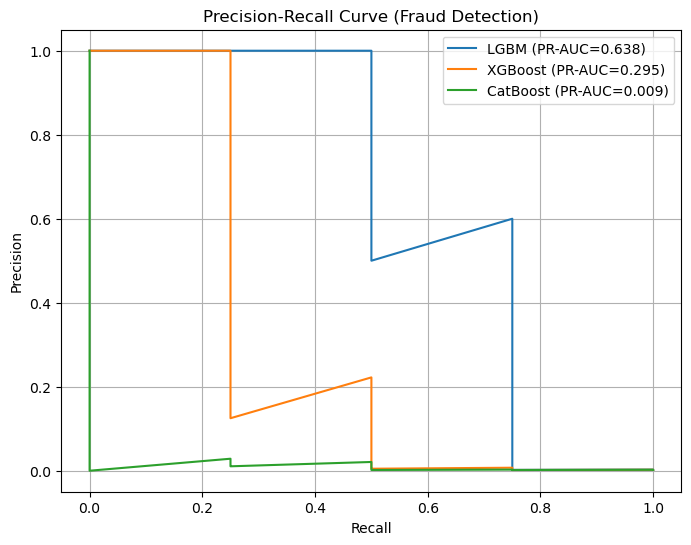

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# 세 모델 확률 예측값 (사기일 확률, 즉 class=1)
y_pred_lgbm = lgb_model.predict_proba(X_val)[:, 1]
y_pred_xgb  = xgb_model.predict_proba(X_val)[:, 1]
y_pred_cat  = cat_model.predict_proba(X_val)[:, 1]

precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_val, y_pred_lgbm)
precision_xgb,  recall_xgb,  _ = precision_recall_curve(y_val, y_pred_xgb)
precision_cat,  recall_cat,  _ = precision_recall_curve(y_val, y_pred_cat)

pr_auc_lgbm = auc(recall_lgbm, precision_lgbm)
pr_auc_xgb  = auc(recall_xgb, precision_xgb)
pr_auc_cat  = auc(recall_cat, precision_cat)

# 그래프 출력
plt.figure(figsize=(8,6))
plt.plot(recall_lgbm, precision_lgbm, label=f"LGBM (PR-AUC={pr_auc_lgbm:.3f})")
plt.plot(recall_xgb,  precision_xgb,  label=f"XGBoost (PR-AUC={pr_auc_xgb:.3f})")
plt.plot(recall_cat,  precision_cat,  label=f"CatBoost (PR-AUC={pr_auc_cat:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Fraud Detection)")
plt.legend()
plt.grid()
plt.show()


In [40]:
#교차검증
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def evaluate_model(model, X, y, cv):
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    f1_scores  = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1)
    pr_scores  = cross_val_score(model, X, y, cv=cv, scoring="average_precision", n_jobs=-1)
    return auc_scores, f1_scores, pr_scores


models = {
    "LightGBM": lgb_model,
    "XGBoost": xgb_model,
    "CatBoost": cat_model
}

for name, model in models.items():
    auc_scores, f1_scores, pr_scores = evaluate_model(model, X, y, cv)
    print(f"\n===== {name} =====")
    print("ROC-AUC:", np.mean(auc_scores).round(4))
    print("F1:", np.mean(f1_scores).round(4))
    print("PR-AUC:", np.mean(pr_scores).round(4))






===== LightGBM =====
ROC-AUC: 0.8403
F1: 0.26
PR-AUC: 0.2429

===== XGBoost =====
ROC-AUC: 0.8395
F1: 0.08
PR-AUC: 0.112

===== CatBoost =====
ROC-AUC: 0.8089
F1: 0.0
PR-AUC: 0.0292


[LightGBM] [Info] Number of positive: 19, number of negative: 9981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

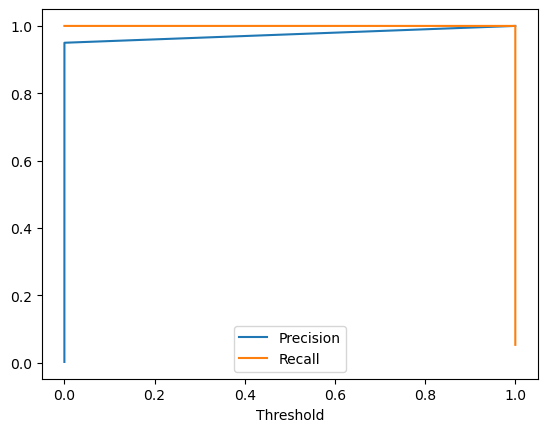

In [41]:
#교차검증 그래프
from sklearn.metrics import precision_recall_curve

y_pred_proba = lgb_model.fit(X, y).predict_proba(X)[:,1]
prec, rec, thres = precision_recall_curve(y, y_pred_proba)

import matplotlib.pyplot as plt
plt.plot(thres, prec[:-1], label="Precision")
plt.plot(thres, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend(); plt.show()


In [42]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, classification_report, confusion_matrix

proba_lgb = lgb_model.predict_proba(X_val)[:, 1]
proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
proba_cat = cat_model.predict_proba(X_val)[:, 1]

weights = [0.2,0.4,0.4]

proba_ensemble = (
    weights[0] * proba_lgb +
    weights[1] * proba_xgb +
    weights[2] * proba_cat
)

preds_ensemble = (proba_ensemble >= 0.5).astype(int)

roc_auc = roc_auc_score(y_val, proba_ensemble)
f1 = f1_score(y_val, preds_ensemble)
pr_auc = average_precision_score(y_val, proba_ensemble)

print("===== Ensemble (Proba 평균) =====")
print("ROC-AUC:", round(roc_auc, 4))
print("F1:", round(f1, 4))
print("PR-AUC:", round(pr_auc, 4))

print("\nClassification Report:")
print(classification_report(y_val, preds_ensemble, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, preds_ensemble))


===== Ensemble (Proba 평균) =====
ROC-AUC: 1.0
F1: 0.0
PR-AUC: 1.0

Classification Report:
              precision    recall  f1-score   support

           0     0.9980    1.0000    0.9990      1996
           1     0.0000    0.0000    0.0000         4

    accuracy                         0.9980      2000
   macro avg     0.4990    0.5000    0.4995      2000
weighted avg     0.9960    0.9980    0.9970      2000


Confusion Matrix:
[[1996    0]
 [   4    0]]


In [43]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, classification_report, confusion_matrix

proba_lgb = lgb_model.predict_proba(X_val)[:, 1]
proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
proba_cat = cat_model.predict_proba(X_val)[:, 1]

weights = [0.2,0.4,0.4]

proba_ensemble = (
    weights[0] * proba_lgb +
    weights[1] * proba_xgb +
    weights[2] * proba_cat
)

preds_ensemble = (proba_ensemble >= 0.3).astype(int)

roc_auc = roc_auc_score(y_val, proba_ensemble)
f1 = f1_score(y_val, preds_ensemble)
pr_auc = average_precision_score(y_val, proba_ensemble)

print("===== Ensemble (Proba 평균) =====")
print("ROC-AUC:", round(roc_auc, 4))
print("F1:", round(f1, 4))
print("PR-AUC:", round(pr_auc, 4))

print("\nClassification Report:")
print(classification_report(y_val, preds_ensemble, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, preds_ensemble))


===== Ensemble (Proba 평균) =====
ROC-AUC: 1.0
F1: 0.0
PR-AUC: 1.0

Classification Report:
              precision    recall  f1-score   support

           0     0.9980    1.0000    0.9990      1996
           1     0.0000    0.0000    0.0000         4

    accuracy                         0.9980      2000
   macro avg     0.4990    0.5000    0.4995      2000
weighted avg     0.9960    0.9980    0.9970      2000


Confusion Matrix:
[[1996    0]
 [   4    0]]


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

thresholds = np.arange(0.1, 0.9, 0.05)
results = []

best_f1, best_th, best_mcc, best_mcc_th = 0, 0, -1, 0

for th in thresholds:
    preds = (proba_ensemble >= th).astype(int)
    prec = precision_score(y_val, preds, zero_division=0)
    rec  = recall_score(y_val, preds, zero_division=0)
    f1   = f1_score(y_val, preds, zero_division=0)
    mcc  = matthews_corrcoef(y_val, preds)
    results.append((th, prec, rec, f1, mcc))
    
    if f1 > best_f1:
        best_f1, best_th = f1, th
    if mcc > best_mcc:
        best_mcc, best_mcc_th = mcc, th

df_results = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1", "MCC"])
print(df_results.round(4))

print(f"\n F1 기준 최적 threshold: {best_th}, F1={best_f1:.4f}")
print(f" MCC 기준 최적 threshold: {best_mcc_th}, MCC={best_mcc:.4f}")

    Threshold  Precision  Recall   F1  MCC
0        0.10        1.0     1.0  1.0  1.0
1        0.15        1.0     1.0  1.0  1.0
2        0.20        1.0     1.0  1.0  1.0
3        0.25        0.0     0.0  0.0  0.0
4        0.30        0.0     0.0  0.0  0.0
5        0.35        0.0     0.0  0.0  0.0
6        0.40        0.0     0.0  0.0  0.0
7        0.45        0.0     0.0  0.0  0.0
8        0.50        0.0     0.0  0.0  0.0
9        0.55        0.0     0.0  0.0  0.0
10       0.60        0.0     0.0  0.0  0.0
11       0.65        0.0     0.0  0.0  0.0
12       0.70        0.0     0.0  0.0  0.0
13       0.75        0.0     0.0  0.0  0.0
14       0.80        0.0     0.0  0.0  0.0
15       0.85        0.0     0.0  0.0  0.0

 F1 기준 최적 threshold: 0.1, F1=1.0000
 MCC 기준 최적 threshold: 0.1, MCC=1.0000


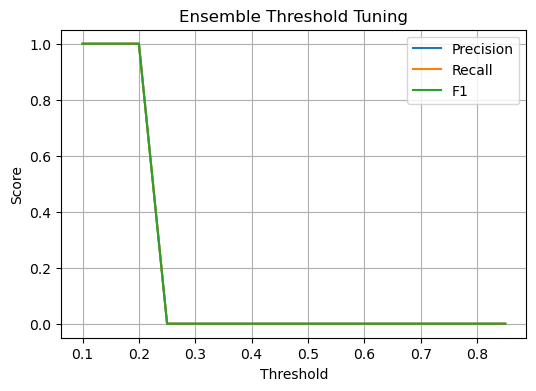

In [45]:
plt.figure(figsize=(6,4))
plt.plot(df_results["Threshold"], df_results["Precision"], label="Precision")
plt.plot(df_results["Threshold"], df_results["Recall"], label="Recall")
plt.plot(df_results["Threshold"], df_results["F1"], label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Ensemble Threshold Tuning")
plt.legend()
plt.grid()
plt.show()

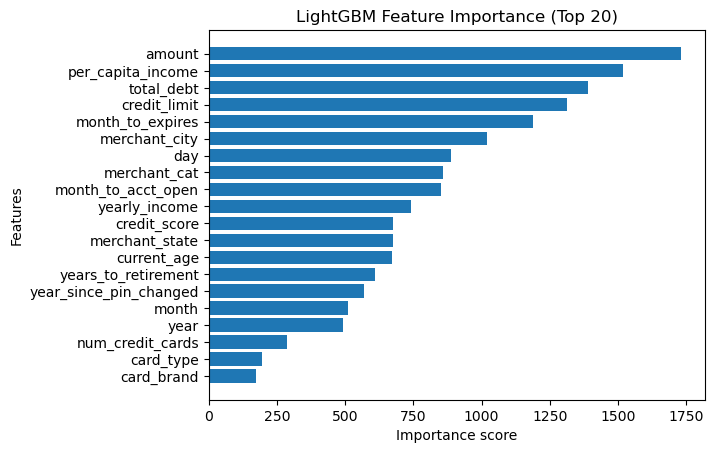

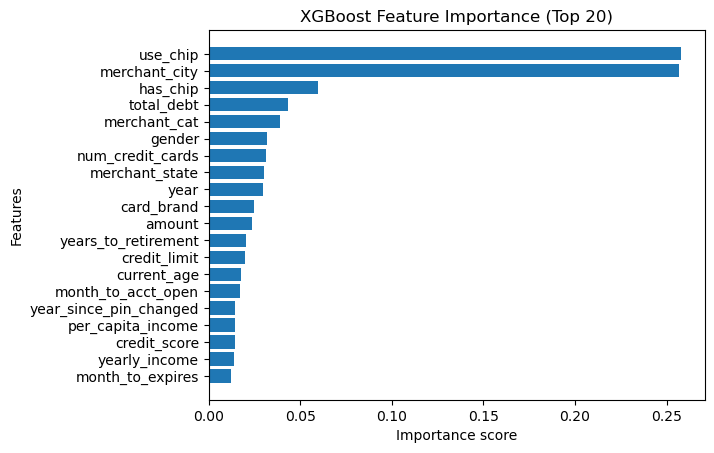

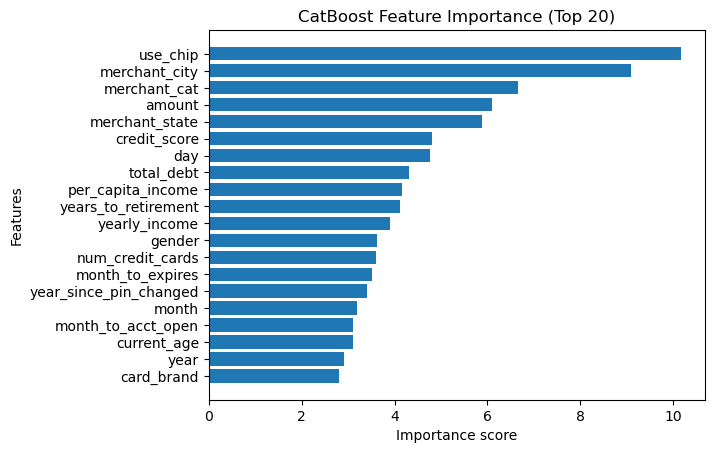

In [46]:
def plot_feature_importance(model_name, features, importances, top_n=20):
    idx = np.argsort(importances)[::-1][:top_n]
    plt.barh(np.array(features)[idx][::-1], np.array(importances)[idx][::-1])
    plt.title(f"{model_name} Feature Importance (Top {top_n})")
    plt.xlabel("Importance score")
    plt.ylabel("Features")
    plt.show()

# LightGBM
fi_lgb = lgb_model.feature_importances_
plot_feature_importance("LightGBM", X_val.columns, fi_lgb)

# XGBoost
fi_xgb = xgb_model.feature_importances_  # numpy array
plot_feature_importance("XGBoost", X_val.columns, fi_xgb)

# CatBoost
fi_cat = cat_model.get_feature_importance()
plot_feature_importance("CatBoost", X_val.columns, fi_cat)


In [ ]:
static

In [ ]:
# import matplotlib.pyplot as plt
# import shap

# #어떤변수가 사기탐지에 기여했는지 확인가능
# # LightGBM Feature Importance
# lgb.plot_importance(lgb_model, max_num_features=20, importance_type="gain")
# plt.title("LightGBM Feature Importance")
# plt.show()


In [ ]:
# # X_unlabeled (400만 데이터, 라벨 없음)
# # 피처 단계에서 x_unlabeled 지정해주기 (사기결과값이 없는 데이터)
# proba_unlabeled = lgb_model.predict_proba(X_unlabeled)[:, 1]

# pred_unlabeled = pd.DataFrame({
#     "transaction_id": X_unlabeled.index,
#     "fraud_probability": proba_unlabeled
# })

# # pred_unlabeled.to_csv("fraud_predictions_unlabeled.csv", index=False)
# # print("fraud_predictions_unlabeled.csv 저장")
# pred_unlabeled["fraud_probability"] = pred_unlabeled["fraud_probability"].round(3)
# print(pred_unlabeled.head()) 
# print(pred_unlabeled.sample(10))



In [ ]:
# # 사기 가능성이 높은/낮은 샘플만 pseudo-label로 사용
# high_conf_mask = (proba_unlabeled > 0.9) | (proba_unlabeled < 0.1)

# X_pseudo = X_unlabeled[high_conf_mask]
# y_pseudo = (proba_unlabeled[high_conf_mask] > 0.5).astype(int)

# # 학습 데이터에 추가
# X_train_new = pd.concat([X_train, X_pseudo])
# y_train_new = pd.concat([y_train, pd.Series(y_pseudo, index=X_pseudo.index)])

# lgb_model_retrained = lgb.LGBMClassifier(
#     n_estimators=500, learning_rate=0.05, num_leaves=64,
#     subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
# )

# xgb_model_retrained = XGBClassifier(
#     n_estimators=500, learning_rate=0.05, max_depth=6,
#     subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1,
#     eval_metric="logloss", use_label_encoder=False
# )

# cat_model_retrained = CatBoostClassifier(
#     iterations=500, learning_rate=0.05, depth=6,
#     subsample=0.8, colsample_bylevel=0.8, random_seed=42,
#     verbose=0
# )

# lgb_model_retrained.fit(X_train_new, y_train_new)

# # 성능 확인
# res_retrained = evaluate_model(lgb_model_retrained, X_val, y_val, "LightGBM (Pseudo-labeled)")


In [ ]:
스태킹
